# MNIST - GAN

## library 불러오기

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### batch size 설정

In [3]:
batch_size = 100

## data 불러오기

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

train_data = datasets.MNIST(root = './mnist_data/', train = True, transform = transform, download = True)
test_data = datasets.MNIST(root = './mnist_data/', train = False, transform = transform, download = False)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mnist_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [6]:
train_data.train_data.size()

torch.Size([60000, 28, 28])

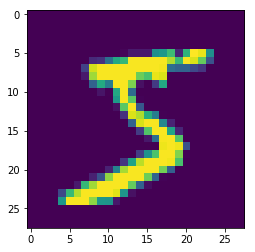

In [7]:
plt.imshow(train_data.train_data.numpy()[0,:,:])

### input pipeline

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

## Generator 구성

In [9]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

## Discriminator 구성

In [10]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

## noise 설정

In [11]:
z_dim = 100

In [12]:
mnist_dim = train_data.train_data.size(1) * train_data.train_data.size(2)
mnist_dim

784

In [13]:
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)

In [14]:
D = Discriminator(mnist_dim).to(device)

In [15]:
criterion = nn.BCELoss()

In [16]:
lr = 0.0002
G_optim = optim.Adam(G.parameters(), lr = lr)
D_optim = optim.Adam(D.parameters(), lr = lr)

In [17]:
def D_train(x):
    D.zero_grad()

    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optim.step()

    return D_loss.data.item()

In [18]:
def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optim.step()

    return G_loss.data.item()

In [ ]:
n_epoch = 100
for e in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

        if batch_idx % 50 == 0:
            print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (e), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        
    test_z = Variable(torch.randn(1, z_dim).to(device))
    generated_samples = G(test_z)
    save_image(generated_samples.view(generated_samples.size(0),1,28,28), 'sample_'+str(e)+'.png')


[1/100]: loss_d: 1.339, loss_g: 0.658
[1/100]: loss_d: 1.014, loss_g: 1.021
[1/100]: loss_d: 0.922, loss_g: 1.274
[1/100]: loss_d: 1.062, loss_g: 1.491
[1/100]: loss_d: 1.036, loss_g: 1.827
[1/100]: loss_d: 1.092, loss_g: 2.451
[1/100]: loss_d: 0.944, loss_g: 2.757
[1/100]: loss_d: 0.821, loss_g: 3.136
[1/100]: loss_d: 0.743, loss_g: 3.610
[1/100]: loss_d: 0.762, loss_g: 3.511
[1/100]: loss_d: 0.807, loss_g: 3.311
[1/100]: loss_d: 0.808, loss_g: 3.422
[2/100]: loss_d: 0.847, loss_g: 1.499
[2/100]: loss_d: 0.798, loss_g: 1.953
[2/100]: loss_d: 0.718, loss_g: 2.519
[2/100]: loss_d: 0.898, loss_g: 2.314
[2/100]: loss_d: 0.873, loss_g: 2.320
[2/100]: loss_d: 0.818, loss_g: 2.445
[2/100]: loss_d: 0.870, loss_g: 2.280
[2/100]: loss_d: 0.912, loss_g: 2.151
[2/100]: loss_d: 0.935, loss_g: 2.088
[2/100]: loss_d: 0.952, loss_g: 1.984
[2/100]: loss_d: 0.971, loss_g: 1.901
[2/100]: loss_d: 0.955, loss_g: 1.872
[3/100]: loss_d: 0.533, loss_g: 3.627
[3/100]: loss_d: 1.376, loss_g: 1.416
[3/100]: los